In [2]:
import pandas as pd
X_train = pd.read_csv("X_train.csv")
X_val   = pd.read_csv("X_val.csv")
X_test  = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").squeeze("columns")
y_val   = pd.read_csv("y_val.csv").squeeze("columns")
y_test  = pd.read_csv("y_test.csv").squeeze("columns")

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
], remainder="drop")

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt",
    class_weight="balanced", random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", rf)])
pipe.fit(X_train, y_train)

y_val_pred = pipe.predict(X_val)
print("Baseline RF — F1(val):", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, digits=3))

Baseline RF — F1(val): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         2

    accuracy                          1.000         4
   macro avg      1.000     1.000     1.000         4
weighted avg      1.000     1.000     1.000         4



In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="f1_macro", n_jobs=-1)
print("CV F1-macro (train):", scores.mean(), "±", scores.std())

CV F1-macro (train): 1.0 ± 0.0


In [6]:
from sklearn.model_selection import GridSearchCV

param = {
  "clf__max_depth": [None, 12, 20, 30],
  "clf__min_samples_split": [2, 5, 10]
}

gs = GridSearchCV(pipe, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_
y_val_best = best_model.predict(X_val)
print("Best RF — F1(val):", f1_score(y_val, y_val_best, average="macro"))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best RF — F1(val): 1.0


F1(test): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         3

    accuracy                          1.000         5
   macro avg      1.000     1.000     1.000         5
weighted avg      1.000     1.000     1.000         5

Confusion Matrix (test):
[[2 0]
 [0 3]]
ROC-AUC(test): 1.0


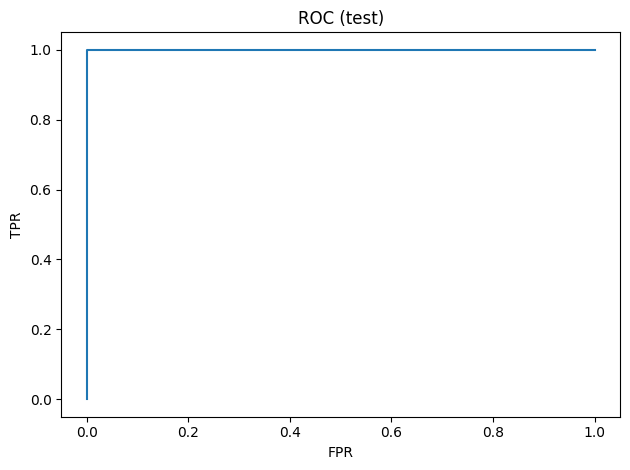

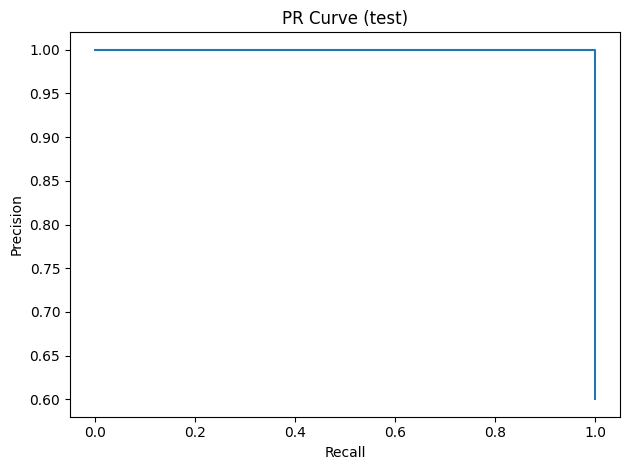

In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

final_model = best_model  # pilih terbaik; jika baseline lebih baik, gunakan pipe

y_test_pred = final_model.predict(X_test)
print("F1(test):", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion Matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (bila ada predict_proba)
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    try:
        print("ROC-AUC(test):", roc_auc_score(y_test, y_test_proba))
    except:
        pass
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
    plt.tight_layout(); plt.savefig("roc_test.png", dpi=120)

    prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (test)")
    plt.tight_layout(); plt.savefig("pr_test.png", dpi=120)

In [8]:
# 6a) Feature importance native (gini)
try:
    import numpy as np
    importances = final_model.named_steps["clf"].feature_importances_
    fn = final_model.named_steps["pre"].get_feature_names_out()
    top = sorted(zip(fn, importances), key=lambda x: x[1], reverse=True)
    print("Top feature importance:")
    for name, val in top[:10]:
        print(f"{name}: {val:.4f}")
except Exception as e:
    print("Feature importance tidak tersedia:", e)

Top feature importance:
num__IPK: 0.2513
num__Waktu_Belajar_Jam: 0.2491
num__IPK_x_Study: 0.2206
num__Rasio_Absensi: 0.1528
num__Jumlah_Absensi: 0.1262


In [9]:
from sklearn.inspection import permutation_importance

r = permutation_importance(final_model, X_val, y_val, 
                           n_repeats=10, random_state=42, n_jobs=-1)

# Urutkan hasil
sorted_idx = r.importances_mean.argsort()[::-1]
for i in sorted_idx:
    print(f"{X_val.columns[i]}: {r.importances_mean[i]:.4f}")


IPK_x_Study: 0.0000
Rasio_Absensi: 0.0000
Waktu_Belajar_Jam: 0.0000
Jumlah_Absensi: 0.0000
IPK: 0.0000


In [10]:
import joblib
joblib.dump(final_model, "rf_model.pkl")
print("Model disimpan sebagai rf_model.pkl")

Model disimpan sebagai rf_model.pkl


In [11]:
# Contoh sekali jalan (input fiktif), sesuaikan nama kolom:
import pandas as pd, joblib
mdl = joblib.load("rf_model.pkl")
sample = pd.DataFrame([{
  "IPK": 3.4,
  "Jumlah_Absensi": 4,
  "Waktu_Belajar_Jam": 7,
  "Rasio_Absensi": 4/14,
  "IPK_x_Study": 3.4*7
}])
print("Prediksi:", int(mdl.predict(sample)[0]))

Prediksi: 1


In [12]:
sample2 = pd.DataFrame([{
  "IPK": 2.0,
  "Jumlah_Absensi": 10,
  "Waktu_Belajar_Jam": 1,
  "Rasio_Absensi": 10/14,
  "IPK_x_Study": 2.0*1
}])
print("Prediksi:", int(mdl.predict(sample2)[0]))


Prediksi: 0
